## Makemore:part3

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
words = open('names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
      X, Y = [], []

      for w in words:
        context = [0] * block_size
        for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          context = context[1:] + [ix] # crop and append

      X = torch.tensor(X)
      Y = torch.tensor(Y)
      print(X.shape, Y.shape)
      return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### PROBLEM 1
#### At initialisation we can almost always see what loss we expect .Here all letters should have same probability at initialisation so loss will be
#### -torch.tensor(1/27.0).log()  ->  (3.2958)
#### but we are getting much more higher loss(27) which indicates very bad initialisation and model is confidently predicting wrong answers

four dimensional example of the problem
logits = torch.tensor([0.0,0.0,5.0,0.0]) by chance low loss but higher chance
is this case [5.0,10,0,0,0.0] very high loss

probs = torch.softmax(logits,dim=0)

loss= -probs[2].log()

To solve this problem we will multiply the initialisation with a small number or all zeros

after initialising weights correctly we get 3. smtg loss initially


In [63]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd*block_size)**0.5)    #* 0.2 
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # we dont want this to be zero
b2 = torch.randn(vocab_size,                      generator=g) * 0 # 0 because adding smtg makes the initial loss high because nn is confidently wrong
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))
parameters = [C, W1,b1, W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 
# how to come up with that 0.2 .. no one does that by hand

In [47]:
(torch.randn(1000000)*0.2).std()

tensor(0.1999)

In [48]:
(5/3)/(30**0.5)

0.3042903097250923

tensor(-0.0164) tensor(0.9983)
tensor(0.0004) tensor(0.9864)


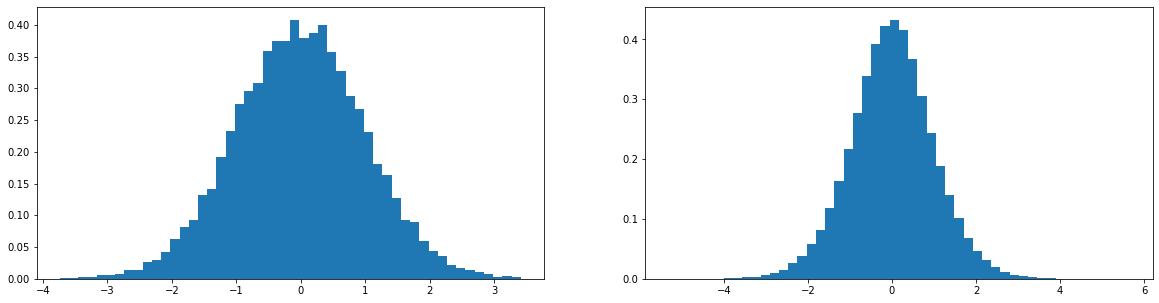

In [41]:
x = torch.randn(1000,10)#gaussian distribution
w = torch.randn(10,200) /10**0.5
y = x@w
print(x.mean(),x.std())#mean is normal,std deviation is normal
print(y.mean(),y.std())# mean is normal but std deviation is different (3.22)
#but we need same activations throughout the nn (unit gaussian)
# to preserve this we need to divide by the sqrt of fanin (num of input elements here 10)
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

In [53]:
hpreact.shape 

torch.Size([64, 200])

In [54]:
hpreact.mean(0,keepdims=True).shape # we need mean of all 64

torch.Size([1, 200])

In [56]:
hpreact.std(0,keepdims=True).shape

torch.Size([1, 200])

In [64]:
max_steps = 200000
batch_size = 32
lossi=[]


for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(64,))
    Xb,Yb = Xtr[ix],Ytr[ix]
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concat into (N, block_size * n_embd)
    #adding bias is wasteful because we are taking mean and subtracting it
    hpreact = embcat@W1 #+ b1 # hidden later pre-activation , we need this to be closer to 0 very similar to logits to solve the tanh problem
    # another easy approach to fix this is batch norm , we need it to be roughly gaussian just normalize them to be gaussian
    # ---------batch_norm---------- #
    # when using batch norm there is a strange thing happening that is  
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact= bngain*(hpreact - bnmeani)/bnstdi +bnbias#doing just this will not help we need to let the neural net play around so we add bnbias and multiply bngain
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
     # we will be adding this batch norm layer throughout the neural net , the hidden state activations are not just the fucntions of the training example but also the function of the examples that happen to come with it
    # acciddentaly in the batch , you  might think this is weird but it is good , it has a regularizing effect because of data augmentation
    h= torch.tanh(hpreact) #hidden layer activation
    logits = h@W2 + b2 #output layer # we need logits comin out to be near to zero at initialisation so b2, 0 at initialisation
    loss = F.cross_entropy(logits,Yb)#loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<100000 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000:3.3131
  10000/ 200000:2.1533
  20000/ 200000:2.3602
  30000/ 200000:2.3621
  40000/ 200000:2.0733
  50000/ 200000:2.2328
  60000/ 200000:1.9960
  70000/ 200000:2.3653
  80000/ 200000:1.9895
  90000/ 200000:2.1185
 100000/ 200000:2.1416
 110000/ 200000:2.1727
 120000/ 200000:2.0256
 130000/ 200000:2.2797
 140000/ 200000:2.1070
 150000/ 200000:2.0685
 160000/ 200000:2.3595
 170000/ 200000:2.1870
 180000/ 200000:1.9606
 190000/ 200000:2.2632


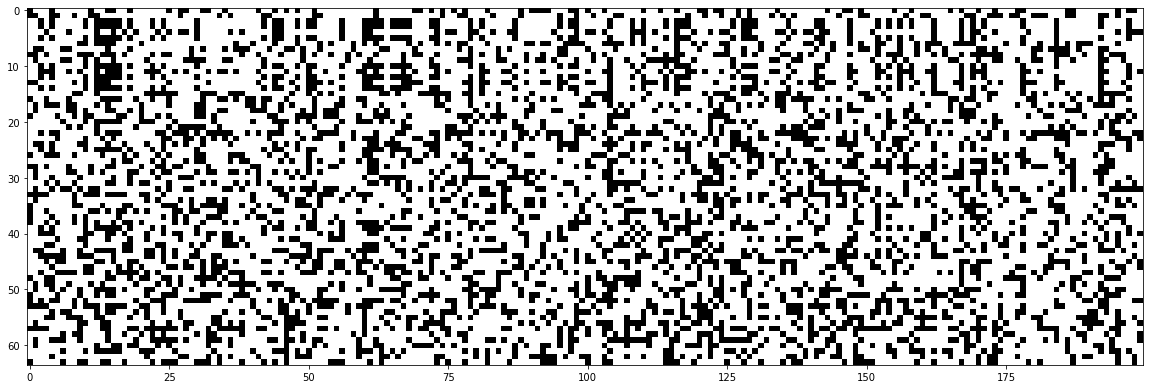

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')
# all the white places below gradients will be destroyed
# if there are columns of white that is a dead neuron


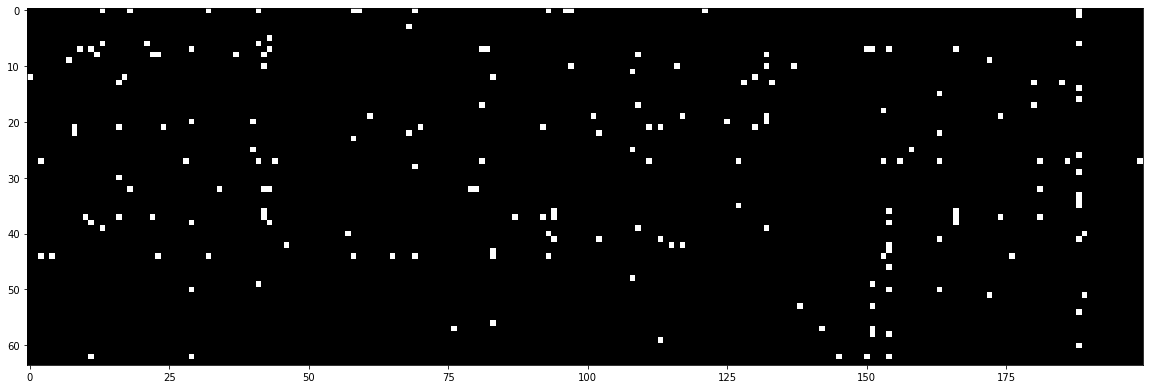

In [33]:
# after fixing 
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

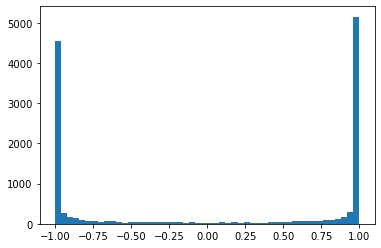

In [23]:
h.shape # ([64,200])
plt.hist(h.view(-1).tolist(),50); # we need to fix this 
# problem is at backpropagation these because slope at tanh =1 or -1 is 0
# so no matter how much you change the gradient model will not learn 
# (1- t**2)* out.grad
#saturating activationss lead to vanishing gradients

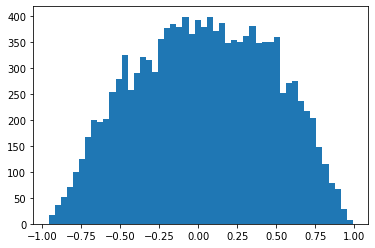

In [28]:
# after fixing
h.shape # ([64,200])
plt.hist(h.view(-1).tolist(),50);

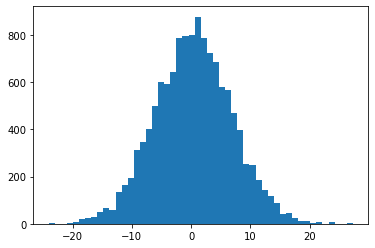

In [24]:
plt.hist(hpreact.view(-1).tolist(),50); # this is very broad

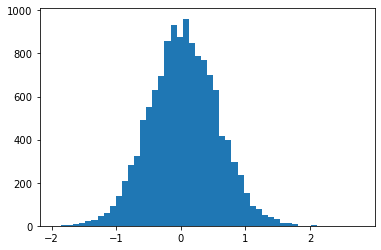

In [29]:
# after fixing
plt.hist(hpreact.view(-1).tolist(),50); # not  broad

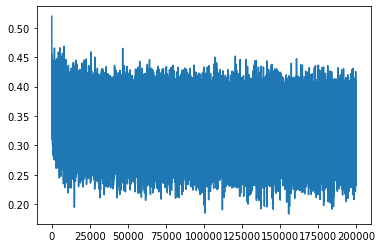

In [19]:
plt.plot(lossi) #now we see that the hockey stick appearance of loss is not there because we initialised well and this helps because the more training time will be given to improve the model rather than shrinking it

In [65]:
#OUR NEURAL NETWORK NOW EXPECTS BATCHES AS INPUTS HOW TO PUT A SINGLE EXAMPLE AND GET SENSIBLE RESULTS
with torch.no_grad():
  # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
   # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
# to avoid the above we just calculate bnmean running and use it
# we do running one  because while training the neural network takes batches and 
# calculates mean and std accross only that batch ,
# but in inference we input only one example not a batch so we calculate the mean_running during
# the training for the whole training set then use it to pass a single example in the inference time

In [67]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact=  embcat@W1+b1
    #hpreact= bngain*(hpreact - hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True) +bnbias
    hpreact = bngain*(hpreact-bnmean_running)/bnstd_running+bnbias #bnmean and bnmean running are almost identical
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0435707569122314
val 2.0998048782348633


#### LOSS WHEN INITIALISATION WAS BAD
     TRAIN ->  2.2308623790740967
     VAL -> 2.249389886856079
#### LOSS WHEN INITIALISATION WAS GOOD
     TRAIN -> 2.117876768112182
     VAL -> 2.157973527908325
#### LOSS WHEN WE FIXED TANH LAYER BEING TOO SATURATED AT INIT
     TRAIN ->2.0703351497650146
     VAL -> 2.11810302734375
#### LOSS WHEN WE FIXED TANH ACCORDING TO THE PAPER
     TRAIN ->2.026627540588379
     VAL -> 2.106279134750366
#### LOSS USING BATCH NORM
    TRAIN -> 2.0443265438079834 ,not expecting improvement
    VAL -> 2.095064401626587
#### LOSS USING BNMEAN RUNNING AND BNSTD RUNNING
    TRAIN -> 2.0435707569122314 ,expecting similar results as above
    VAL -> 2.0435707569122314

In [13]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h  = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mili.
taty.
sacelyn.
jazhetrieperric.
kaqui.
nellana.
chaiivon.
leig.
dham.
por.
dessan.
sulin.
alian.
quinathon.
jaryni.
jaxee.
dusab.


In [ ]:
# PYTORCHYFYING

In [56]:
class Linear:#linear layers torch.nn.Linear(in_features,out_features,bias=True)
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #kaiming initialisation
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):# calculates x@W +b
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #our own batch norm1d
  #for us affine will be true we will be using gamma and beta ,dtype by default is float32
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta #pytorch does not have .out we are calculating to measure things
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
#   layers[-1].weight *= 0.1 # because the last layer is batch norm we would not change the weight to be less confident we will be changing the gamma
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [57]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():#log10 because nice visaulisation
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  if i >= 1000:
    break
     # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

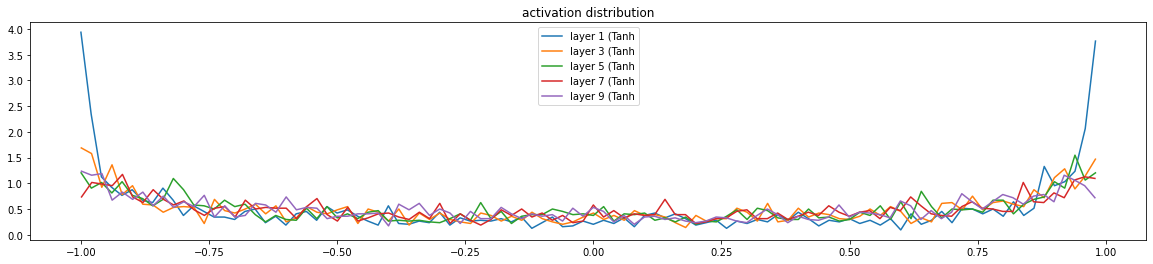

In [23]:
# visualize histograms in forward pass activations specifically at the tanh layers
#when gain is set to 5/3
# good setting as it stabilises std at a good region and saturation is also good
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

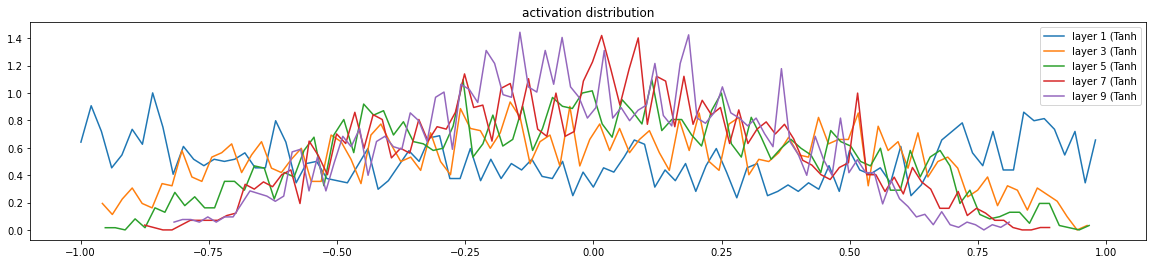

In [26]:
#if there is no gain # 1
# the kaiming initialisation maintains the std of 1 but tanh is squashing function so it shrinks
#we need to put a gain to fight the squashing
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.01, std 0.41, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.20, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.10, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.05, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

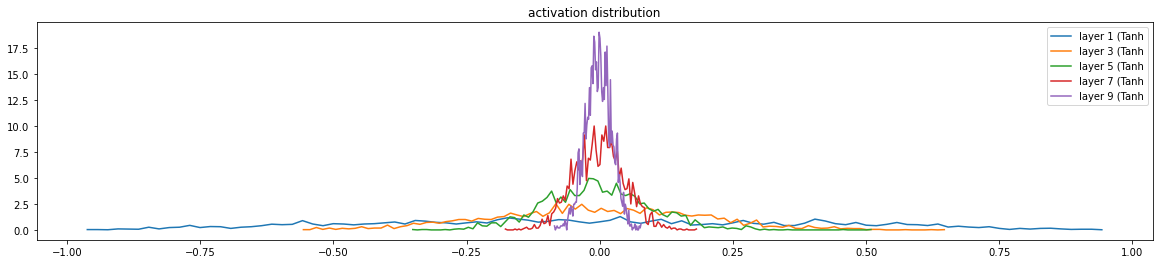

In [34]:
# if gain was 0.5
# actiavtions are shrinking to zer0
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.03, std 1.00, saturated: 97.72%
layer 3 (      Tanh): mean -0.07, std 0.98, saturated: 91.22%
layer 5 (      Tanh): mean +0.02, std 0.98, saturated: 91.84%
layer 7 (      Tanh): mean +0.03, std 0.98, saturated: 89.44%
layer 9 (      Tanh): mean -0.01, std 0.98, saturated: 89.78%


Text(0.5, 1.0, 'activation distribution')

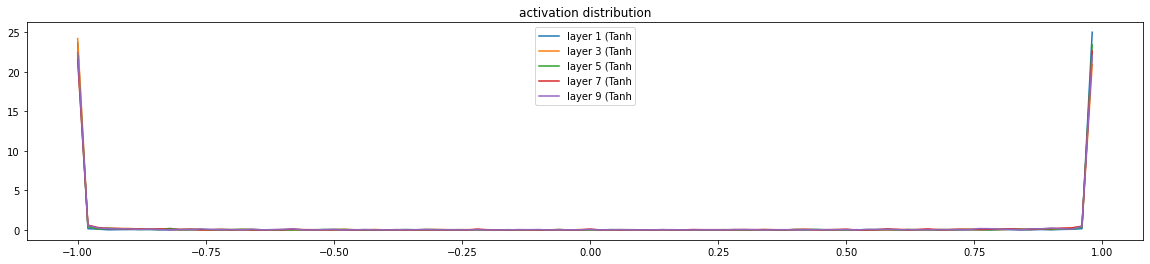

In [52]:
#this can also show if anything is wrong for example if we forget to put the kaimiing initailisation
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

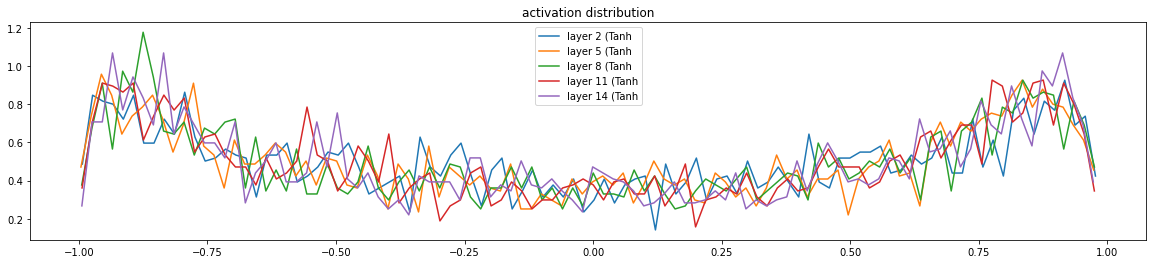

In [58]:
#if we use batch norm
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

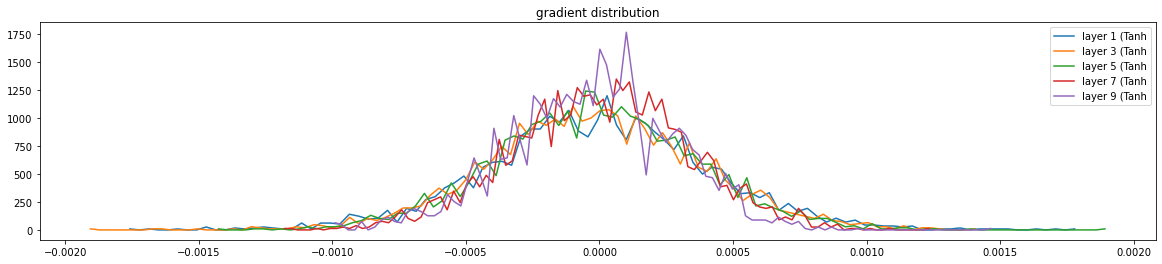

In [38]:
# we can do the exact same thing with gradients
# visualize histograms
# we need that all the layers have similar gradients not shrinking or exploding
# when gain is 5/3
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad #******#
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561152e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


Text(0.5, 1.0, 'gradient distribution')

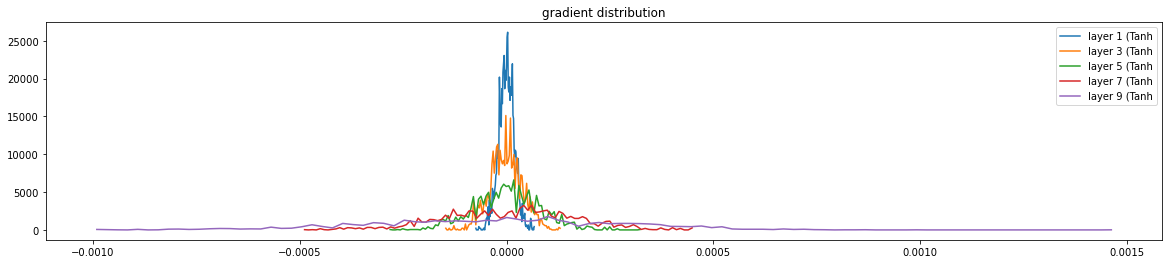

In [35]:
#when gain is 0.5
# not good the layers have different gradients and last layer is literally flat
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad #******#
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 1 (      Tanh): mean -0.001160, std 1.167974e-01
layer 3 (      Tanh): mean +0.000108, std 3.402133e-02
layer 5 (      Tanh): mean -0.000386, std 1.325033e-02
layer 7 (      Tanh): mean +0.000075, std 4.645841e-03
layer 9 (      Tanh): mean +0.000056, std 1.811773e-03


Text(0.5, 1.0, 'gradient distribution')

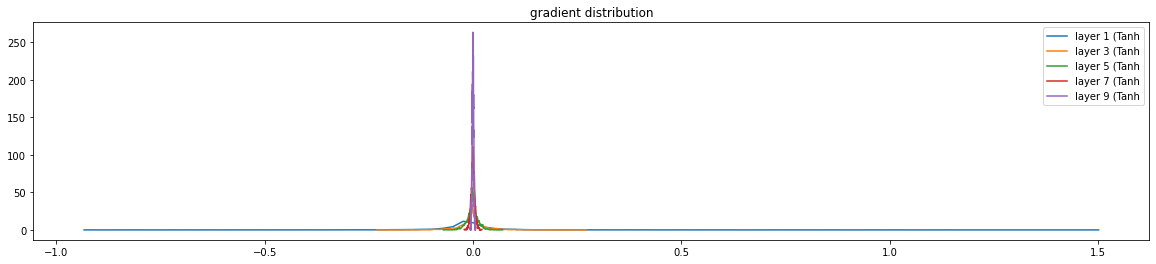

In [53]:
#this can also show if anything is wrong for example if we forget to put the kaimiing initailisation
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad #******#
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682953e-03
layer 5 (      Tanh): mean -0.000000, std 3.262608e-03
layer 8 (      Tanh): mean -0.000000, std 2.973730e-03
layer 11 (      Tanh): mean -0.000000, std 2.741111e-03
layer 14 (      Tanh): mean +0.000000, std 2.584294e-03


Text(0.5, 1.0, 'gradient distribution')

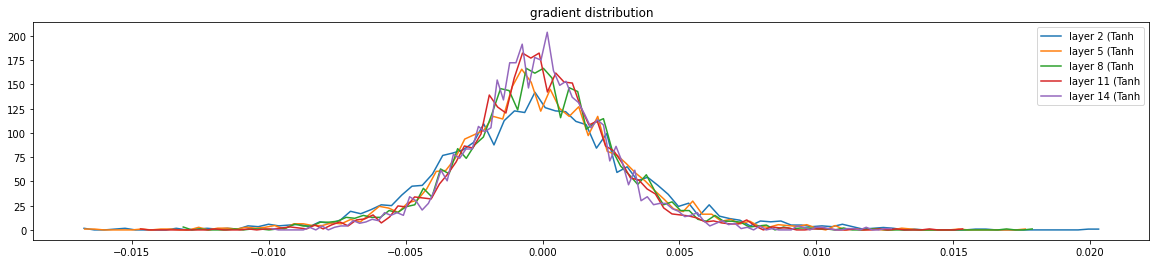

In [59]:
# if we use batch norm
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad #******#
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# if we remove all the tanh layers and keep all linear layers and keep gain at 5/3 
# its bad the actiavations are different for different layers and gradients start to die.
# but if we keep gain as 1 for these linear layers it turns out to be ok
# but it collapses to a single layer single huge layer, if we plot input against the output its just a linear function which is not helpful if we want to find out difficult functions

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158123e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328202e+00


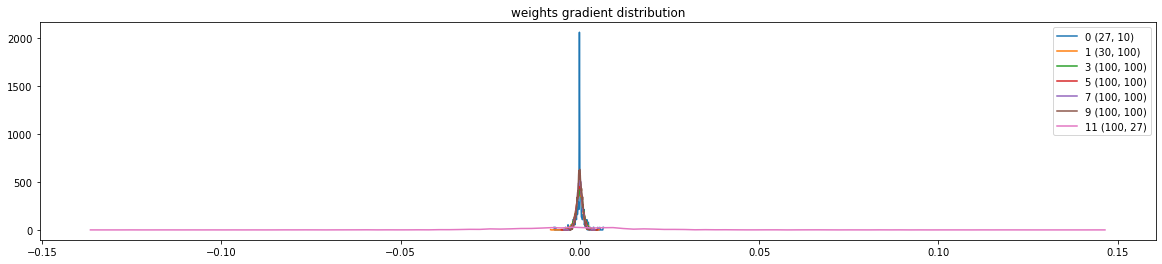

In [39]:
#analysing the parameters
#this is at initialisation
#this is at gain 5/3 
# all other actiavtions and gradients are stable but this looks a little wierd
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821213e-03 | grad:data ratio 4.653363e-02
weight (100, 100) | mean -0.000107 | std 6.655621e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086040e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


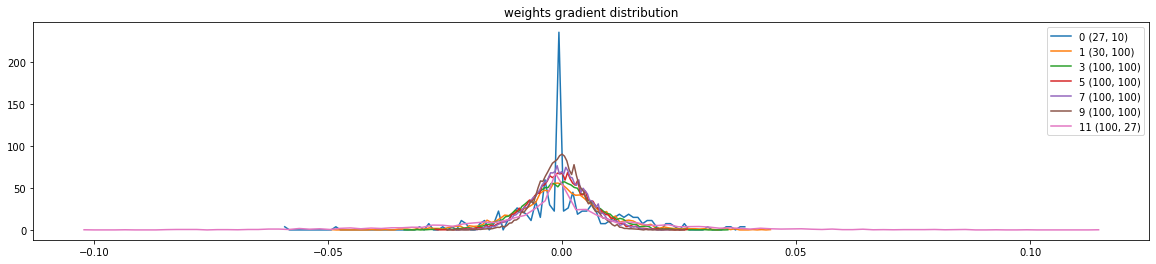

In [42]:
# after 1000 steps / iterations
# the last layers srd of -2 degree is worrying
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

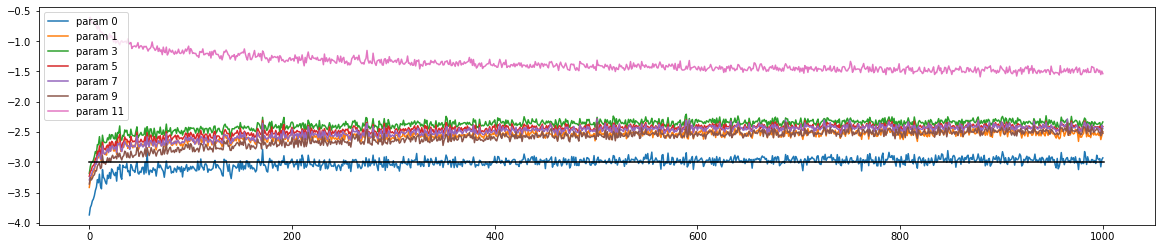

In [45]:
#gradient to data ratio is not that informative we need how much it is changing 
# so we need update to data ratio because that is the amount we are changing it
# one more plot
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
# we made the *0.1 to make the last layer less confident thats y it is a outlier in this graph

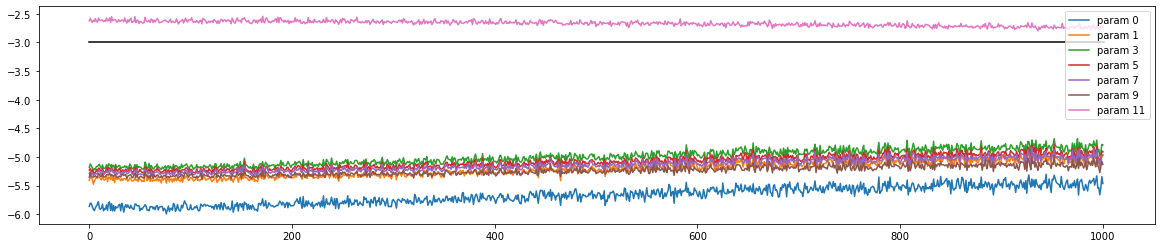

In [48]:
# if our learning rate was too low then it will below the black line our parameters arent learning fast enough
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
# see its way below the blaxk line
# this is another way to see the learning rate...

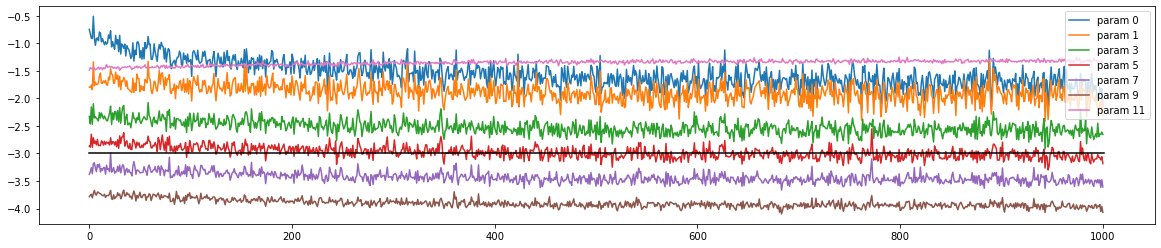

In [54]:
#this can also show if anything is wrong for example if we forget to put the kaimiing initailisation
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

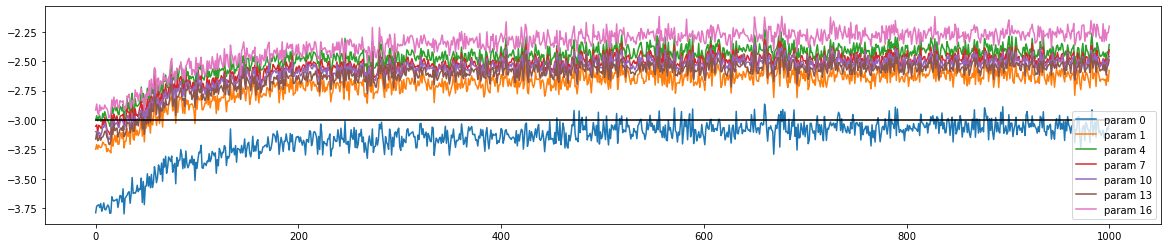

In [60]:
#if we use batch norm
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [61]:
# EXERCISE 01 -->
#  I did not get around to seeing what happens when you initialize all weights and biases to zero.
#     Try this and train the neural net. 
#     You might think either that 
#     1) the network trains just fine or 
#     2) the network doesn't train at all,
#        but actually it is 
#     3) the network trains but only partially, and achieves a pretty bad final performance. 
#     Inspect the gradients and activations to figure out what is happening and why the network is only partially training,
#     and what part is being trained exactly.

In [72]:
class Linear:#linear layers torch.nn.Linear(in_features,out_features,bias=True)
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.zeros((fan_in, fan_out)) #/ fan_in**0.5 #kaiming initialisation
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):# calculates x@W +b
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: #our own batch norm1d
  #for us affine will be true we will be using gamma and beta ,dtype by default is float32
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta #pytorch does not have .out we are calculating to measure things
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
#   layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1 # because the last layer is batch norm we would not change the weight to be less confident we will be changing the gamma
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [86]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():#log10 because nice visaulisation
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  
  if i >= 40000:
    break
     # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.0246
  10000/ 200000: 2.5313
  20000/ 200000: 2.8780
  30000/ 200000: 2.7096
  40000/ 200000: 3.1864


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

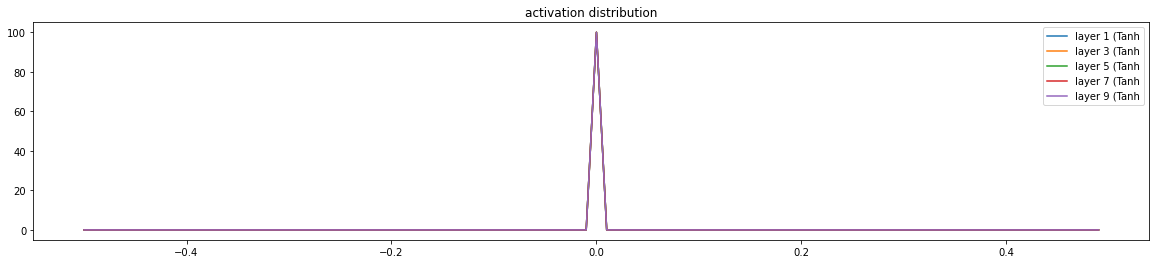

In [87]:
#if we use batch norm
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


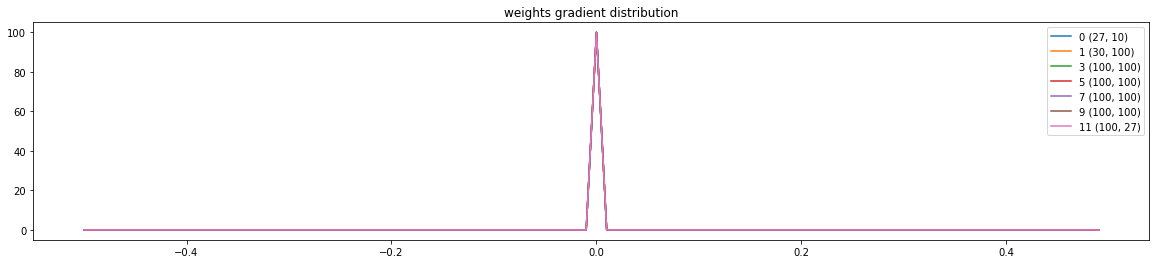

In [88]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

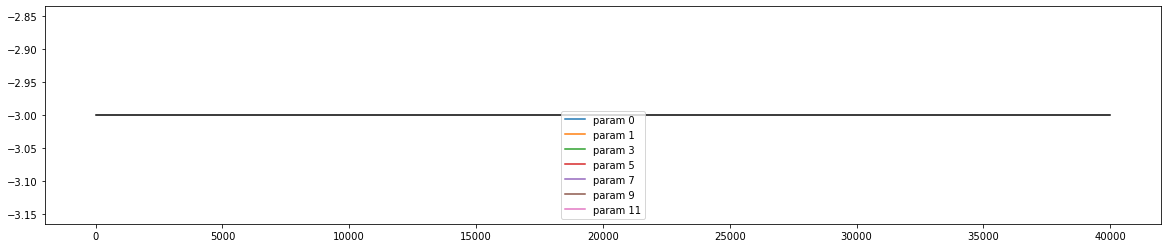

In [89]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
# -E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. 
# has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, 
# effectively erasing the need to forward it at test time. 
# Set up a small 3-layer MLP with batchnorms, train the network, 
# then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. 
# Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, 
# and can be thrown out after training is done! pretty cool.

In [92]:
n_embd = 10
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) 
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd*block_size)**0.5)    #* 0.2 
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #for not being waste ful
W2 = torch.randn((n_hidden, n_hidden),          generator=g)  
b2 = torch.randn(n_hidden,                      generator=g) 
W3 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # we dont want this to be zero
b3 = torch.randn(vocab_size,                      generator=g) * 0 # for decreasing the initial loss
parameters = [C, W1, W2,b2,W3,b3]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

51897


In [93]:
max_steps = 200000
batch_size = 32
lossi=[]


for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(64,))
    Xb,Yb = Xtr[ix],Ytr[ix]
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concat into (N, block_size * n_embd)
    hpreact = embcat@W1 #+ b1 
    
    # ---------batch_norm---------- #
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact= ((hpreact - bnmeani)/bnstdi)@W2 +b2 #batch norm folded in between layers
    h= torch.tanh(hpreact) #hidden layer activation
    logits = h@W3 + b3 #output layer 
    #loss function
    loss = F.cross_entropy(logits,Yb)    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<100000 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())


    
    

      0/ 200000:3.3083
  10000/ 200000:2.2090
  20000/ 200000:2.0811
  30000/ 200000:2.2356
  40000/ 200000:2.4318
  50000/ 200000:2.3807
  60000/ 200000:2.1111
  70000/ 200000:1.9108
  80000/ 200000:1.8748
  90000/ 200000:1.9891
 100000/ 200000:2.0203
 110000/ 200000:2.2988
 120000/ 200000:2.1231
 130000/ 200000:1.9678
 140000/ 200000:2.1745
 150000/ 200000:2.1448
 160000/ 200000:2.1953
 170000/ 200000:2.1620
 180000/ 200000:2.2307
 190000/ 200000:2.2851


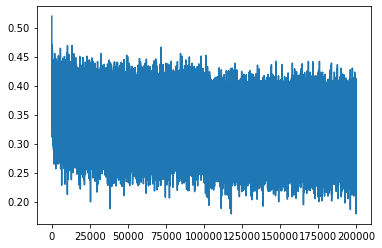

In [94]:
plt.plot(lossi)

In [95]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss_bn(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  # hpreact = ((hpreact - bnmean_running) / bnstd_running ) @ W2 + b2
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)@ W2 + b2
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W3 + b3 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss_bn('train')
split_loss_bn('val')

train 2.0644900798797607
val 2.1173319816589355


In [96]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [97]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [98]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#   hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0677599906921387
val 2.1054909229278564


## loss when folded batchnorm layer
### train ->2.0644900798797607
### val-> 2.1173319816589355
## loss when normal batchnorm layer
### train ->  2.0677599906921387
### val -> 2.1054909229278564 